## 0. Подготовка данных

### 0.1 Импорт библиотек

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import collections as coll
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import train_test_split # Загружаем специальный удобный инструмент для разделения датасета
from sklearn.preprocessing import MinMaxScaler # инструмент для масштабирования каждой функции до заданного диапазона
from sklearn.feature_selection import f_classif

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Konstantin\AppData\Roaming\nltk_data...


### 0.2 Константы

In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты был воспроизводим
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### 0.3 Импорт данных

In [4]:
# Подгрузим наши данные из соревнования (код для kaggle):

#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [6]:
# Подгрузим наши данные из соревнования (код для ПК):
os.chdir(r'D:\IDE\Project 3\kaggle\input\sf-booking')

In [7]:
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн


### 0.4 Визуальный оценка данных

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [9]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [11]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [12]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [13]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [14]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [16]:
hotels_nulls = data.isnull().sum()
nulls = hotels_nulls[hotels_nulls > 0]
print('Признаки и количество пропущенных значений:\n{}'.format(nulls))

Признаки и количество пропущенных значений:
lat    3268
lng    3268
dtype: int64


## 1. Проектирование признаков (Feature Engineering)

### 1.1 Географическое расположение

In [17]:
#Выделим название города и страны из адреса:
# Обратим внимание, что есть United Kingdom - состоящее из двух слов
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
data['hotel_country'] = data['hotel_country'].apply(lambda x:'United Kingdom' if x == 'Kingdom' else x)
country_list = list(data['hotel_country'].unique()) # в датасете отели из 6 стран

data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2])
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)
city = list(data['city'].unique())
city# и 6 городов-столиц

['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']

In [18]:
# Вариант 1: заполним координаты отеля медианным значением координат города


#for city in set(data['city']):
    #med_lat = data[data['city'] == city ]['lat'].median()
    #med_lng = data[data['city'] == city ]['lng'].median()
    
    #data.loc[(data.city == city), 'lat'] = med_lat
    #data.loc[(data.city == city), 'lng'] = med_lng

# Вариант 2: заполним пустые координаты отеля нулевыми значениями координат
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

# Вариант 3: заполним пустые координаты отеля значениями координат города:
values_lat = {
    'Milan': 45.4642700,
    'Amsterdam': 52.3740300,
    'Barcelona': 41.3887900,
    'London': 51.5085300,
    'Paris': 48.8534100,
    'Vienna': 48.2084900
}

values_lng = {
    'Milan': 9.1895100,
    'Amsterdam': 4.8896900,
    'Barcelona': 2.1589900,
    'London': -0.1257400,
    'Paris': 2.3488000,
    'Vienna': 16.3720800
}

# заполняем широту
data['lat'] = data[['city','lat']].apply(lambda x: values_lat[x.city] if np.isnan(x.lat) else x.lat, axis=1)
# заполняем долготу
data['lng'] = data[['city','lng']].apply(lambda x: values_lng[x.city] if np.isnan(x.lng) else x.lng, axis=1)

display(data.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,city
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,Milan
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,Barcelona
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0,Italy,Milan
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0,Netherlands,Amsterdam


In [19]:
#Кодируем название страны и создаём новый признак
data['hotel_country'] = data['hotel_country'].astype('category')
data['hotel_country_code'] = data['hotel_country'].cat.codes

### 1.2 Гражданство рецензента

In [20]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip()) #отсекаем пробелы в начале и в конце строки
print('Рецензенты из {} стран оставили отзывы и оценки об отеле.'.format(data['reviewer_nationality'].nunique()))

# кодируем информацию о стране рецензента:
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
data['reviewer_nationality_code'] = data['reviewer_nationality'].cat.codes

Рецензенты из 227 стран оставили отзывы и оценки об отеле.


### 1.3 Анализ тегов

In [21]:
#Выделим из столбца с тэгами: количество ночей в отеле, количество уникальных тэгов и самые популярные тэги
def count_tags(tags):
    express = re.findall("'[^\'](.+?)[^\']'", tags)
    return express

print('Количество уникальных тэгов: ', data['tags'].apply(count_tags).explode().nunique())

Количество уникальных тэгов:  2428


In [22]:
# Определяем ТОП-3 тегов представлен в наибольшем числе отзывов, а также ТОП-15
cnt = coll.Counter() 
for i, row in data['tags'].items():
    tmp = row.replace("[' ", "")
    tmp = tmp.replace(" ']", '')
    tmp = tmp.split(" ', ' ")
    cnt.update(tmp)
print(cnt.most_common(3))

for key, values in cnt.most_common(15): 
    print(key)

[('Leisure trip', 417778), ('Submitted from a mobile device', 307640), ('Couple', 252294)]
Leisure trip
Submitted from a mobile device
Couple
Stayed 1 night
Stayed 2 nights
Solo traveler
Stayed 3 nights
Business trip
Group
Family with young children
Stayed 4 nights
Double Room
Standard Double Room
Superior Double Room
Family with older children


In [23]:
# Введем 3 новых признака из ТОП-3 тэгов
# is_trip (если встречается тэг "Leisure trip")
data['is_trip'] = data['tags'].apply(lambda x: 1 if ('Leisure trip' in x) else 0)
# is_mobile (если встречается тэг "Submitted from a mobile device")
data['is_mobile'] = data['tags'].apply(lambda x: 1 if ('Submitted from a mobile device' in x) else 0)
# is_couple (если встречается тэг "Couple")
data['is_couple'] = data['tags'].apply(lambda x: 1 if ('Couple' in x) else 0)

<AxesSubplot:xlabel='count_nights', ylabel="('count', 'reviewer_score')">

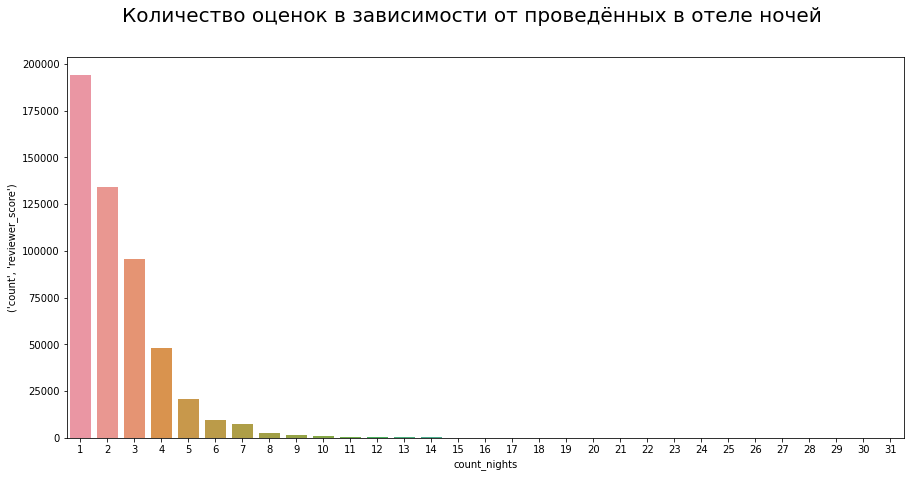

In [24]:
# Введем новый признак count_nights (количество ночей)
def count_nights(tags):
    express = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    return express

data['count_nights'] = data['tags'].apply(count_nights)

def convert(feature):
    for elem, num in enumerate(feature):
        return np.int8(num)
    
data['count_nights'] = data['count_nights'].apply(convert).convert_dtypes().fillna(1)

# Построим график зависимости количества оценок от количества ночей в отели
pivot_nights = pd.pivot_table(
    data=data,
    index='count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig1, ax1 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Количество оценок в зависимости от проведённых в отеле ночей', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')])

### 1.4 Анализ дат и сезонности отзывов

In [25]:
# Представим признак days_since_review в виде числа дней
def count_days(feature):
    count = re.findall(r'\d+', feature)
    return count
    
data['days_since_review'] = data['days_since_review'].apply(count_days)
data['days_since_review'] = data['days_since_review'].apply(convert).convert_dtypes()

# Приведём столбец review_date к типу datetime64:
data['review_date'] = pd.to_datetime(data['review_date'])

# Выделим новый признак: месяц года ("review_month")
data['review_month'] = data['review_date'].dt.month
score_month = data[data['sample']==1].pivot_table(
    values='reviewer_score',
    index='review_month',
    aggfunc='mean'
    )
score_month

,reviewer_score
review_month,
1,8.482245
2,8.534773
3,8.481505
4,8.432322
5,8.385711
6,8.387010
7,8.339102
8,8.412986
9,8.293349


(8.0, 8.7)

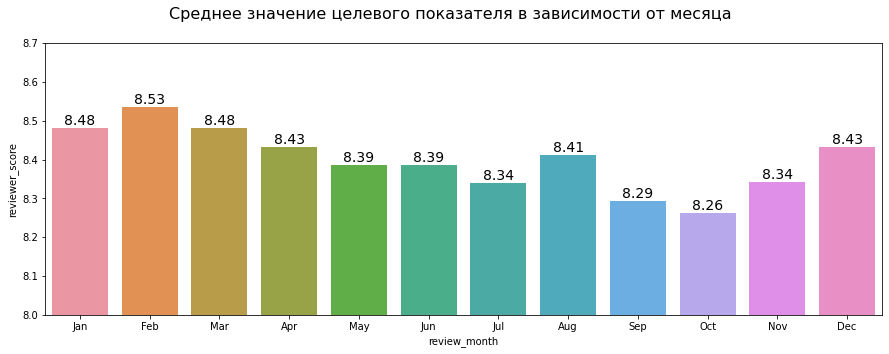

In [26]:
# Посмотрим на распределение оценок по месяцам
fig2, ax2 = plt.subplots(figsize=(15, 5))
plt.suptitle('Среднее значение целевого показателя в зависимости от месяца', size=16)
bar_month = sns.barplot(
    x=score_month.index, 
    y=score_month['reviewer_score'])
ax2.set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

for p in bar_month.patches:
    bar_month.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7)

(30000.0, 50000.0)

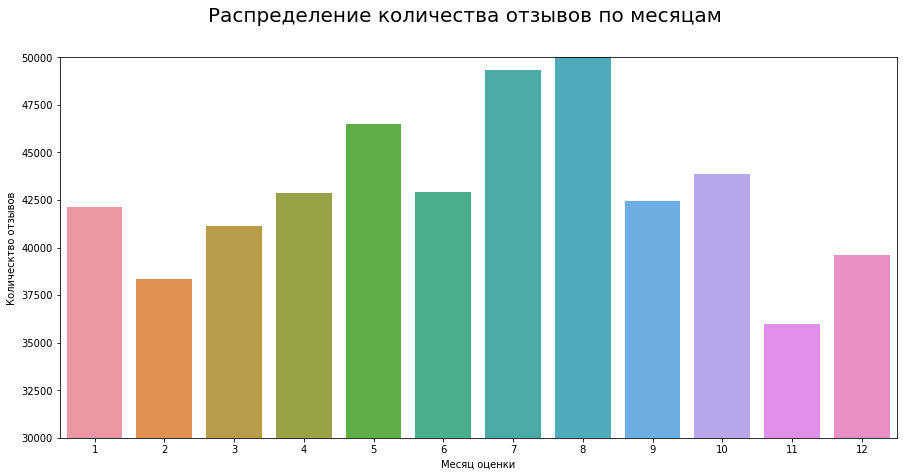

In [27]:
# Также посмотрим на распределение количества отзывов по месяцам
pivot_review = pd.pivot_table(
    data=data,
    index='review_month', 
    values='reviewer_score', 
    aggfunc=['count'])

fig1, ax3 = plt.subplots(figsize=(15, 7))

plt.suptitle(
    'Распределение количества отзывов по месяцам', size=20)
sns.barplot(x=pivot_review.index, y=pivot_review[('count', 'reviewer_score')])
ax3.set_xlabel('Месяц оценки')
ax3.set_ylabel('Колическтво отзывов')
plt.ylim(30000, 50000)

Как видно картина по графикам отличается: с одной стороны минимальные оценки ставят в сентябре-октябре, с другой стороны, в эти месяцы количество отзывов на уровне среднегодовых значений. В тоже время, обращает на себя внимание количество положительных оценок в феврале, когда количества отзывов минимально. 

### 1.5 Анализ общего количества отзывов ("total_number_of_reviews_reviewer_has_given")

In [28]:
data['total_number_of_reviews_reviewer_has_given'].groupby(
   pd.cut(data['total_number_of_reviews_reviewer_has_given'], 
   np.arange(0, 500, 50))
   ).agg('count')

data['total_number_of_reviews_reviewer_has_given'] = \
   data['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))

### 1.6 Семантический анализ негативных и позитивных отзывов

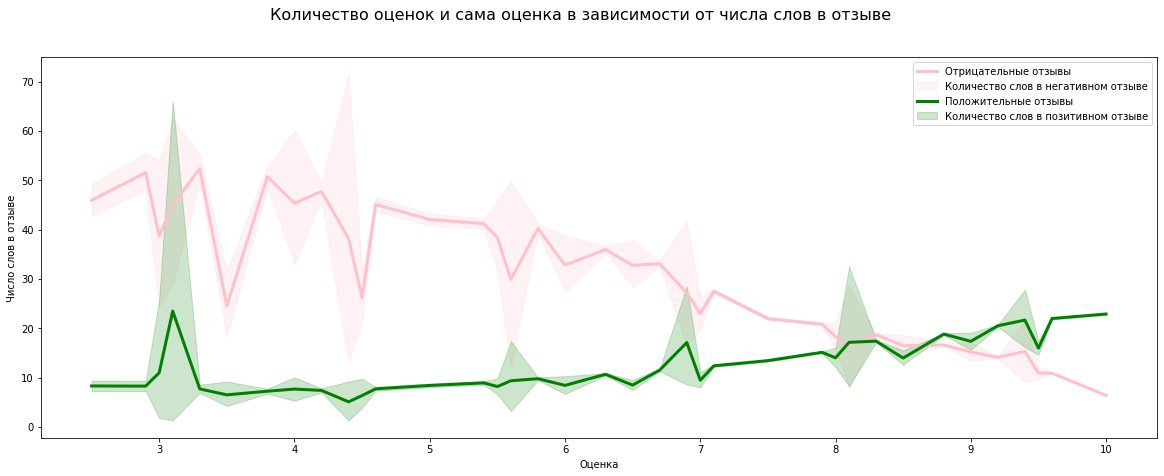

In [29]:
# Посмотрим на зависимость количества оценок и числа слов в отзыве
fig4, ax4 = plt.subplots(figsize=(20, 7))
plt.suptitle('Количество оценок и сама оценка в зависимости от числа слов в отзыве', size=16)
negative = sns.lineplot(
    data=data[data['sample']==1],
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='pink', linewidth=3
)
positive = sns.lineplot(
    data=data[data['sample']==1],
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=3
)
ax4.set_xlabel('Оценка')
ax4.set_ylabel('Число слов в отзыве')
ax4.legend(
    ['Отрицательные отзывы', 'Количество слов в негативном отзыве', 'Положительные отзывы', 'Количество слов в позитивном отзыве'],
    loc='upper right',
    fontsize=10
    )

Из графика видно, что для отрицательных отзывов: чем ниже оценка, тем больше количество слов в отзыве. Для положительных отзывов: количество слов в отзыве возрастает с оценкой - чем больше понравился отель, теи больше постоялец хочет его отметить.
Странно выглядят отрицательные отзывы, когда человек ставит высокую оценку, и наоборот.

In [30]:
# Вычислим долю слов положительных комментариев среди всех комментариев. Пометим строку, если количество слов в пложительном комментарии преобладает над количеством слов в отрицательном.
data['review_total_positive_word_counts_norm']  = pd.DataFrame(
    MinMaxScaler().fit_transform(pd.DataFrame(data['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

data['review_total_negative_word_counts_norm']  = pd.DataFrame(
    MinMaxScaler().fit_transform(pd.DataFrame(data['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

data['review_total_word_diff_norm'] = data['review_total_positive_word_counts_norm'] - data['review_total_negative_word_counts_norm']

data['more_positive'] = data['review_total_word_diff_norm'].apply(lambda x: 1 if x >= 0 else 0)

data.drop(
    ['review_total_positive_word_counts_norm', 'review_total_negative_word_counts_norm'], 
    axis=1, inplace=True)

data['review_total_word_sum'] = \
    data['review_total_positive_word_counts'] + \
    data['review_total_negative_word_counts']

# пополам отрицательных и положительных
data['positive_words_proportion'] = data.apply( lambda x: 0.5 if x['review_total_word_sum'] == 0 \
    else x['review_total_positive_word_counts'] / x['review_total_word_sum'],axis=1)

data.drop('review_total_word_sum', axis = 1, inplace=True)

Для глубокого анализа отзывов (из структуры, эмоциональной окраски, качества) воспользуемся библиотекой VADER (класс SentimentIntensityAnalyzer) из библиотеки NLTK. Подробно можно почитать здесь: http://espressocode.top/python-sentiment-analysis-using-vader/.

In [31]:
# Создаём объекты SentimentIntensityAnalyzer
positive = SentimentIntensityAnalyzer()
negative = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(negative.polarity_scores(example), '\n')

# добавим контекст:
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}
negative.lexicon.update(negative_words)
positive.lexicon.update(positive_words)

print(f' - после преобразований (для негативного контекста):')
print(negative.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(positive.polarity_scores(example))

# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(negative.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(negative.polarity_scores(example))

# меняем метки отсутствия частей отзыва:
data['negative_review_temp'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

data['negative_review_sentiments'] = data['negative_review_temp'].apply(lambda x: negative.polarity_scores(x))

data['positive_review_sentiments'] = data['positive_review_temp'].apply(lambda x: positive.polarity_scores(x))

# формируем новые признаки:
data['neg_review_sentiments_neg'] = data['negative_review_sentiments'].apply(lambda x: x['neg'])
data['neg_review_sentiments_neu'] = data['negative_review_sentiments'].apply(lambda x: x['neu'])
data['neg_review_sentiments_pos'] = data['negative_review_sentiments'].apply(lambda x: x['pos'])
data['neg_review_sentiments_compound'] = data['negative_review_sentiments'].apply(lambda x: x['compound'])

data['pos_review_sentiments_neg'] = data['positive_review_sentiments'].apply(lambda x: x['neg'])
data['pos_review_sentiments_neu'] = data['positive_review_sentiments'].apply(lambda x: x['neu'])
data['pos_review_sentiments_pos'] = data['positive_review_sentiments'].apply(lambda x: x['pos'])
data['pos_review_sentiments_compound'] = data['positive_review_sentiments'].apply(lambda x: x['compound'])

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  category      
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## 2. Отбор признаков
### 2.1 Очистка датасета от неинформативных и вспомогательных признаков

In [33]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

# также избавимся от других нечисловых признаков: category, datetime64[ns]
cat_date_columns = [cd for cd in data.columns if ((data[cd].dtypes.name == 'category') or (data[cd].dtypes == 'datetime64[ns]'))]
data.drop(cat_date_columns, axis = 1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   days_since_review                           515738 non-null  Int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

Как видно после очистки количество столбцов уменьшилось с 41 до 28

In [34]:
def get_top_unique_values(df, level=0):
   """
    Функция для получения инфомации по уникальным значениям в признаках

    :param df: Датафрейм для анализа
    :param level: Уровень уникальности в %, признаки ниже этого уровня не выводятся
    :return: Возвращает датафрейм с именем признака, количестве уникальных значений, наиболее часто повторяющимся
    уникальным значением, сколько % от выборки это значение занимает, количество повторов
   """

   cols = list(df.columns)

   # создаём пустой список
   unique_list = []

   for col in cols:
      col_lev = round(df[col].value_counts(normalize=True).values[0] * 100, 2)

      if col_lev > level:
            item = (
               col, 
               df[col].nunique(), 
               df[col].value_counts(normalize=True).index[0], 
               col_lev, 
               df[col].value_counts().values[0]
               )
            # добавляем кортеж в список
            unique_list.append(item)

   unique_values = pd.DataFrame(
      unique_list,
      columns=['Column Name', 'Count Unique', 'Top Value', 'Top Value %', 'Top Value Count']
      )

   return unique_values

get_top_unique_values(data, level=95)

,Column Name,Count Unique,Top Value,Top Value %,Top Value Count


Как видно список неинформативных признаков (с количество неуникальных значений больше 95%) пуст

In [35]:
data.nunique(dropna=False)

additional_number_of_scoring                    480
average_score                                    34
review_total_negative_word_counts               402
total_number_of_reviews                        1142
review_total_positive_word_counts               365
total_number_of_reviews_reviewer_has_given      198
days_since_review                               256
lat                                            1475
lng                                            1475
sample                                            2
reviewer_score                                   38
hotel_country_code                                6
reviewer_nationality_code                       227
is_trip                                           2
is_mobile                                         2
is_couple                                         2
count_nights                                     31
review_month                                     12
review_total_word_diff_norm                   17974
more_positiv

### 2.2 Анализ мультиколлинеарности

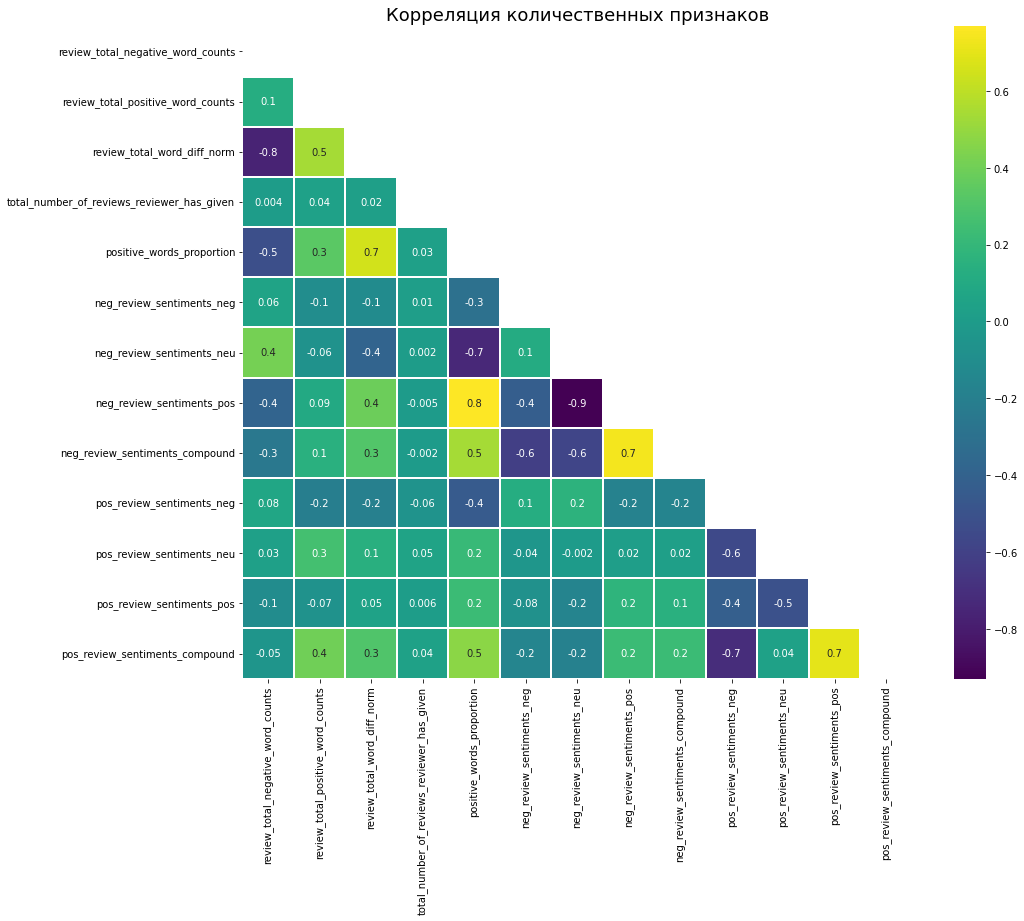

In [36]:
#Разделим признаки по типу
#Количественные
cols_num = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'review_total_word_diff_norm',
    'total_number_of_reviews_reviewer_has_given',
    'positive_words_proportion',
    'neg_review_sentiments_neg',
    'neg_review_sentiments_neu',
    'neg_review_sentiments_pos',
    'neg_review_sentiments_compound',
    'pos_review_sentiments_neg',
    'pos_review_sentiments_neu',
    'pos_review_sentiments_pos',
    'pos_review_sentiments_compound'   
]
#Категориальные
cols_cat = [
    'lat',
    'lng',
    'is_trip',
    'is_mobile',
    'is_couple',
    'additional_number_of_scoring',
    'average_score',
    'total_number_of_reviews',
    'days_since_review',
    'hotel_country_code',
    'reviewer_nationality_code',
    'count_nights',
    'review_month',
    'more_positive'
]
#Построим тепловую диаграмму корреляции количественных признаков
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = data[cols_num].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='viridis',
            fmt='.1g')
ax_.set_title('Корреляция количественных признаков', fontsize=18)
plt.show()

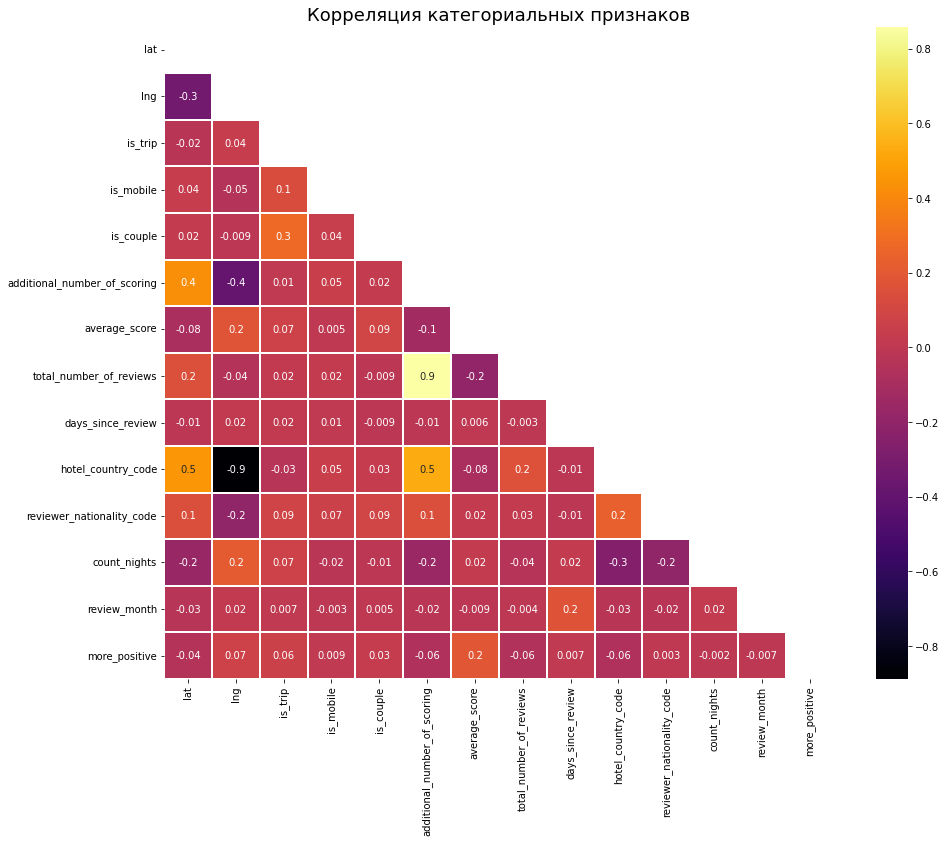

In [37]:
#Отметим количественные признаки с корреляцией больше 0,8
del_cols = ['neg_review_sentiments_neu', 'review_total_word_diff_norm']

#Построим тепловую диаграмму корреляции категориальных признаков
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = data[cols_cat].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax_, 
            mask=mask, 
            cmap='inferno',
            fmt='.1g')
ax_.set_title('Корреляция категориальных признаков', fontsize=18)
plt.show()

In [38]:
#Отметим категориальные признаки с корреляцией больше 0,8
del_cols += ['additional_number_of_scoring', 'hotel_country_code']
#Удаляем признаки, попавшие в список del_cols
data.drop(del_cols, axis = 1, inplace=True)
print('Осталось признаков: {}'.format(data.shape[1]))

Осталось признаков: 25


### 2.3 Анализ значимости признаков

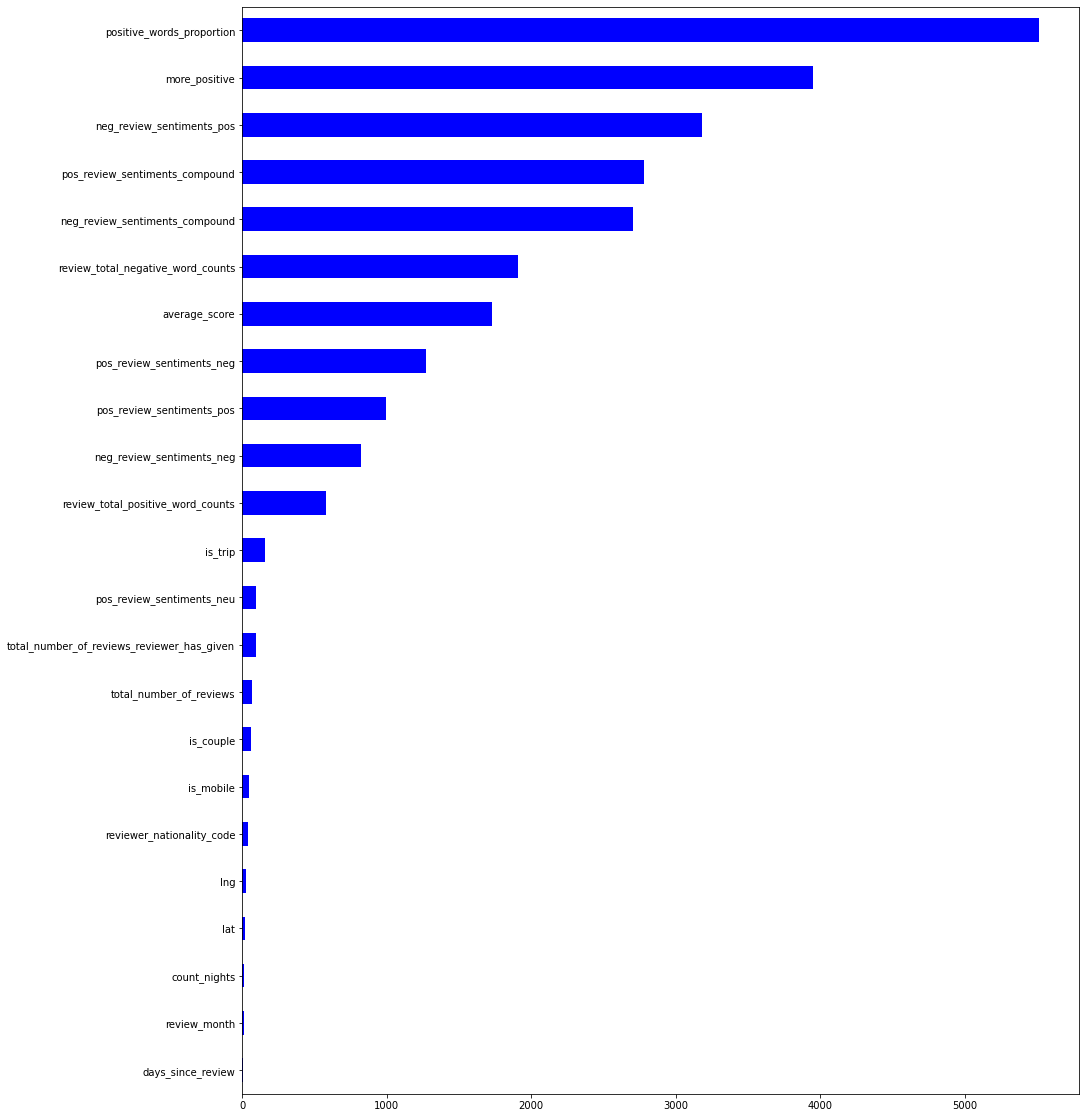

In [39]:
#Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для числовых признаков — тест ANOVA:
y = data.query('sample == 1').drop(['sample'], axis=1)['reviewer_score'].values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='blue');

In [40]:
#Также удалим признаки, почти не коррелирующие с целевым показателем: days_since_review, review_month , count_nights
cols_for_del = ['days_since_review', 'review_month', 'count_nights']
data.drop(cols_for_del, axis = 1, inplace=True)
print('ВСЕГО ПРИЗНАКОВ: {}'.format(data.shape[1]))

ВСЕГО ПРИЗНАКОВ: 22


## 3. Обучение модели

In [41]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [42]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [43]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 21), (386803, 21), (386803, 20), (309442, 20), (77361, 20))

In [44]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [45]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


In [46]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.13


<AxesSubplot:>

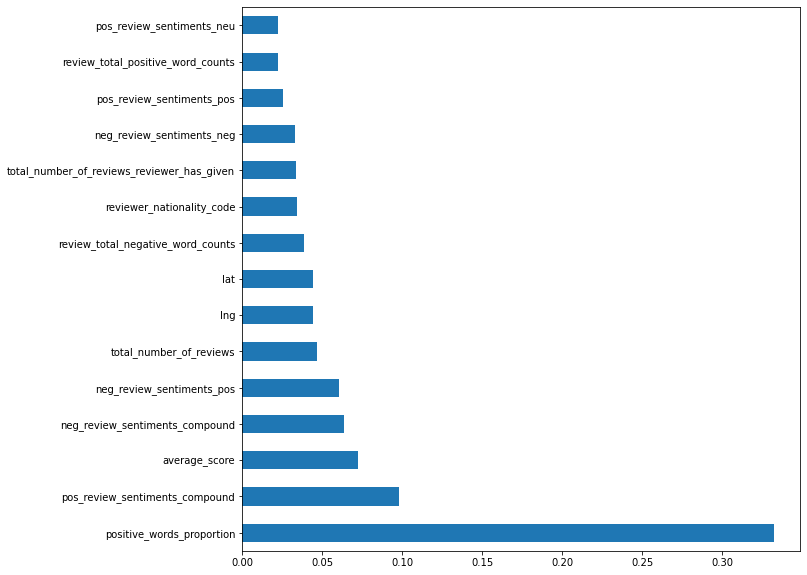

In [47]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [48]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,reviewer_nationality_code,is_trip,...,is_couple,more_positive,positive_words_proportion,neg_review_sentiments_neg,neg_review_sentiments_pos,neg_review_sentiments_compound,pos_review_sentiments_neg,pos_review_sentiments_neu,pos_review_sentiments_pos,pos_review_sentiments_compound
16278,7.5,3,5180,2,1.791759,51.514879,-0.160650,0.0,176,0,...,0,0,0.400000,0.000,0.000,0.0000,0.000,1.000,0.000,0.0000
48517,7.5,25,1733,14,0.693147,51.519586,-0.158480,0.0,214,0,...,0,0,0.358974,0.000,0.056,0.0772,0.065,0.432,0.503,0.8442
79997,9.3,14,720,7,3.401197,52.370261,4.903249,0.0,14,0,...,0,0,0.333333,0.000,0.000,0.0000,0.000,0.208,0.792,0.9081
31133,8.0,34,1069,2,1.098612,51.505454,-0.226222,0.0,214,0,...,0,0,0.055556,0.342,0.000,-0.8733,1.000,0.000,0.000,-0.9325
117871,8.1,4,1918,6,0.693147,41.393863,2.156804,0.0,214,0,...,0,1,0.600000,0.000,0.000,0.0000,0.000,0.164,0.836,0.8807
1043,8.4,10,3911,68,1.791759,52.376752,4.904618,0.0,216,0,...,0,1,0.871795,0.149,0.000,-0.1027,0.000,0.776,0.224,0.9475
12584,8.3,26,4684,12,0.693147,51.491374,-0.121419,0.0,214,1,...,1,0,0.315789,0.115,0.107,-0.0516,0.000,0.385,0.615,0.9041
30099,8.3,0,168,4,0.693147,48.873485,2.348511,0.0,14,1,...,1,1,1.000000,0.000,1.000,0.5574,0.000,0.339,0.661,0.5994
11245,8.9,3,3168,59,2.564949,51.528677,-0.128349,0.0,214,0,...,0,1,0.951613,0.000,1.000,0.9325,0.000,0.638,0.362,0.9753
3096,8.7,2,493,9,2.890372,48.886467,2.294891,0.0,213,1,...,1,1,0.818182,0.000,1.000,0.9325,0.000,0.161,0.839,0.9744


In [49]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [50]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [51]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.1s finished


In [52]:
predict_submission

array([8.446, 7.856, 8.111, ..., 7.865, 9.527, 7.784])

In [53]:
list(sample_submission)

['reviewer_score', 'id']

In [54]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.446,488440
1,7.856,274649
2,8.111,374688
3,9.752,404352
4,9.565,451596
5,9.030,302161
6,7.537,317079
7,7.569,13963
8,8.272,159785
9,7.427,195089
